# LightGBM

En este notebook vamos a desarrollar el algoritmo de LightGBM que seleccionamos frente al resto de modelos, profundizando las distintos parámetros que podemos seleccionar y ajustándolo a nuestro problema, con el fin de obtener los mejores resultados de predicción. Los pasos a seguir en este notebook serán:

- Búsqueda de los mejores hiperparámetros mediante CV
- Matriz de confusión
- Curva ROC
- Curva de Ganancia
- Búsqueda del Umbral óptimo

## Librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, recall_score, precision_score, make_scorer,
                            roc_auc_score, f1_score, accuracy_score, fbeta_score, ConfusionMatrixDisplay
from scikitplot.metrics import plot_cumulative_gain
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier

## Cargamos los datos

In [2]:
pd_fraude_train_t = pd.read_csv('./data/pd_train_processed.csv')
pd_fraude_test_t = pd.read_csv('./data/pd_test_processed.csv')

X_test_t = pd_fraude_test_t.drop(columns=['Unnamed: 0', 'fraud_bool'])
y_test_t = pd_fraude_test_t['fraud_bool']

X_test_t.columns

Index(['name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'phone_home_valid', 'bank_months_count', 'foreign_request',
       'session_length_in_minutes', 'device_distinct_emails_8w', 'month',
       'ratio_inc_cred', 'payment_type_AB', 'payment_type_AC',
       'payment_type_AD', 'payment_type_AE', 'employment_status_CB',
       'employment_status_CC', 'employment_status_CD', 'employment_status_CE',
       'employment_status_CF', 'employment_status_CG', 'housing_status_BB',
       'housing_status_BC', 'housing_status_BD', 'housing_status_BE',
       'housing_status_BF', 'housing_status_BG', 'device_os_macintosh',
       'device_os_other', 'device_os_windows', 'device_os_x11'],
      dtype='object')

## Búsqueda de hiperparámetros

Una parte muy importante de la selección del modelo final es la búsqueda de hiperparámetros. Esto consiste en probar muchas combinaciones de los hiperparámetros del modelo seleccionado, y ver qué configuración nos da los mejores resultados de predicción. 

Este proceso se realiza habitualmente mediante Validación Cruzada, siendo dos métodos muy comunes GridSearchCV y RandomizedSearchCV. La principal diferencia es que el GridSearchCV realiza una búsqueda de todas las combinaciones posibles de los hiperparámetros que hemos especificado, mientras que el RandomizedSearchCV hace una búsqueda aleatoria de los hiperparámetros que hemos especificado, siendo el número de combinaciones totales un número que hemos elegido nosotros. Por norma general, el método de GridSearchCV suele ser más costoso en recursos y tiempo que el RandomizedSearchCV si se usan muchos hiperparámetros. Teniendo todo lo anterior en cuenta, hemos decidido que vamos a usar RandomizedSeachCV para nuestros datos.

En nuestro caso, el modelo que vamos a usar es el LightGBM y los hiperparámetros con los que vamos a hacer la búsqueda son:
- learning_rate
- n_estimators
- num_leaves
- max_depth
- subsample
- colsample_bytree
- min_child_samples

En el notebook de selección de modelos, también decidimos utilizar una técnica de undersampling en nuestro modelo final de LightGBM, configurándolo para que tuviese una proporción de la variable objetivo del 20% y no estuviese tan desbalanceada, pero con el fin de que tampoco se sobreentrenase

In [3]:
rs_02 = RandomUnderSampler(random_state=33, sampling_strategy=0.2)

#Balancing the train dataset
X_train_rs_02, y_train_rs_02 = rs_02.fit_resample(pd_fraude_train_t.drop(columns=['Unnamed: 0', 'fraud_bool']), 
                                                  pd_fraude_train_t['fraud_bool'])

X_train_rs_02.shape

(52938, 37)

In [4]:
%%time

lgbm_classifier = LGBMClassifier(objective='binary', random_state=33, verbose=-1)

#This is the space in which the hyperparameters that we are going to study will move.
espacio_hiperparametros = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [300, 350, 400, 450, 500, 550, 600],
    'num_leaves': [3, 5, 7, 10, 12, 20, 40],
    'max_depth': [3, 7, 12, 16, 20, 25],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [3, 5, 7, 10, 20, 30]
}

#We are going to configure the strategy so that it evaluates the CV based on the F2-score
f2_score = make_scorer(fbeta_score, beta=2)

#Hyperparameters' Search
random_search = RandomizedSearchCV(
    estimator=lgbm_classifier,
    param_distributions=espacio_hiperparametros,
    n_iter=100,
    scoring=f2_score,
    cv=5,
    verbose=2,
    random_state=33,
    n_jobs=-1
)

random_search.fit(X_train_rs_02, y_train_rs_02)

best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores hiperparámetros: {'subsample': 0.8, 'num_leaves': 3, 'n_estimators': 500, 'min_child_samples': 30, 'max_depth': 7, 'learning_rate': 0.5, 'colsample_bytree': 1.0}
CPU times: total: 36.9 s
Wall time: 3min 47s


In [5]:
#We introduce the hyperparameters that the CV has found
light_gbm = LGBMClassifier(
    colsample_bytree = 1.0,
    learning_rate = 0.5,
    max_depth = 7,
    min_child_samples = 30,
    n_estimators = 500,
    num_leaves = 3,
    subsample = 0.8, 
    verbose=-1
)

light_gbm.fit(X_train_rs_02, y_train_rs_02)
y_pred_light_gbm = light_gbm.predict(X_test_t)

Light GBM
Accuracy score: 0.952
Recall score: 0.467
Precision score: 0.109
F1 score: 0.177
F2 score: 0.282


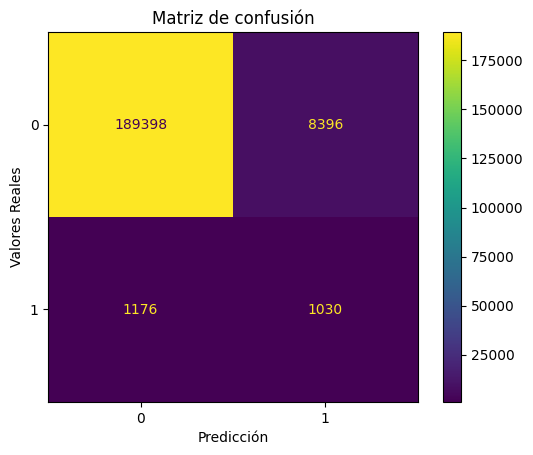

In [15]:
#Metrics
accuracy_light_gbm = accuracy_score(y_test_t, y_pred_light_gbm)
recall_light_gbm = recall_score(y_test_t, y_pred_light_gbm)
precision_light_gbm = precision_score(y_test_t, y_pred_light_gbm)
f1_light_gbm = f1_score(y_test_t, y_pred_light_gbm)
f2_light_gbm = fbeta_score(y_test_t, y_pred_light_gbm, beta=2)
matriz_confusion_light_gbm = confusion_matrix(y_test_t, y_pred_light_gbm)

print("Light GBM")
print("Accuracy score: %.3f" % accuracy_light_gbm)
print("Recall score: %.3f" % recall_light_gbm)
print("Precision score: %.3f" % precision_light_gbm)
print("F1 score: %.3f" % f1_light_gbm)
print("F2 score: %.3f" % f2_light_gbm)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_light_gbm)
disp.plot()
plt.xlabel("Predicción")
plt.ylabel("Valores Reales")
plt.title("Matriz de confusión")
plt.show()

### Nota importante

En un notebook anexo del trabajo, hemos realizado distintas pruebas donde hemos probado configuraciones de variables con el fin de obtener aquella combinación que nos proporcionase los mejores resultados de predicción. Las pruebas se han realizado con los mismos parámetros de CV y teniendo el dataset el mismo tipo de transformaciones, a excepción de las variables que se han utilizado.

Después de diversas pruebas, hemos llegado a que obtenemos los mejores resultados eliminando las siguientes variables:

- 'device_fraud_count'
- 'phone_mobile_valid'
- 'velocity_6h'
- 'source'

Y la confifuración de hiperparámtros es la siguiente:

- learning_rate = 0.5
- n_estimators = 500
- num_leaves = 3
- max_depth = 7
- subsample = 0.8
- colsample_bytree = 1.0
- min_child_samples = 30

Todas las pruebas realizadas se puedes ver en el notebook 'Anexo.ipynb'

## Comprobación de sobreajuste en el modelo

Es importante asegurarse de que no se ha producido sobreajuste (overfitting) en el modelo. Esto ocurre cuando un modelo se ajusta demasiado a los datos de entrenamiento, capturando patrones específicos en lugar de aprender la verdadera relación subyacente. Para comprobar el sobreajuste, se utiliza comúnmente la comparación del rendimiento del modelo en conjuntos de train y test. Si el rendimiento en el conjunto de train es significativamente mejor que en el conjunto de test, podría indicar sobreajuste. Es fundamental encontrar un equilibrio que garantice un rendimiento robusto tanto en los datos utilizados para el entrenamiento como en datos no observados.

In [18]:
train_best_param = pd.read_csv('./data/pd_train_best_param.csv')
test_best_param = pd.read_csv('./data/pd_test_best_param.csv')


X_train = train_best_param.drop(columns=['Unnamed: 0', 'fraud_bool'])
y_train = train_best_param['fraud_bool']
X_test = test_best_param.drop(columns=['Unnamed: 0', 'fraud_bool'])
y_test = test_best_param['fraud_bool']

X_train.columns

Index(['name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'email_is_free', 'phone_home_valid',
       'bank_months_count', 'has_other_cards', 'foreign_request',
       'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'month', 'ratio_inc_cred',
       'payment_type_AB', 'payment_type_AC', 'payment_type_AD',
       'payment_type_AE', 'employment_status_CB', 'employment_status_CC',
       'employment_status_CD', 'employment_status_CE', 'employment_status_CF',
       'employment_status_CG', 'housing_status_BB', 'housing_status_BC',
       'housing_status_BD', 'housing_status_BE', 'housing_status_BF',
       'housing_status_BG', 'device_os_macintosh', 'device_os_other',
       'device_os_windows', 'devi

In [21]:
#We introduce the hyperparameters that we got from the CV
light_gbm_mejor = LGBMClassifier(
    colsample_bytree = 1.0,
    learning_rate = 0.5,
    max_depth = 7,
    min_child_samples = 30,
    n_estimators = 500,
    num_leaves = 3,
    subsample = 0.8, 
    verbose=-1
)

#We adjust the model
light_gbm_mejor.fit(X_train, y_train)

#We get the prediction in the train and test datsets 
y_pred_test = light_gbm_mejor.predict(X_test)
y_pred_train = light_gbm_mejor.predict(X_train)

#We get the metrics for train and test
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)
recall_train = recall_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred_test)
precision_train = precision_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)
f2_test = fbeta_score(y_test, y_pred_test, beta=2)
f2_train = fbeta_score(y_train, y_pred_train, beta=2)
matriz_confusion_test = confusion_matrix(y_test, y_pred_test)
matriz_confusion_train = confusion_matrix(y_train, y_pred_train)


print("Accuracy score test: %.3f" % accuracy_test)
print("Accuracy score train: %.3f" % accuracy_train, "\n")
print("Recall score test: %.3f" % recall_test)
print("Recall score train: %.3f" % recall_train, "\n")
print("Precision score test: %.3f" % precision_test)
print("Precision score train: %.3f" % precision_train, "\n")
print("F1 score test: %.3f" % f1_test)
print("F1 score train: %.3f" % f1_train, "\n")
print("F2 score test: %.3f" % f2_test)
print("F2 score train: %.3f" % f2_train, "\n")
print("Matriz de confusión test:", '\n', matriz_confusion_test, '\n')
print("Matriz de confusión train:", '\n', matriz_confusion_train, '\n')

Accuracy score test: 0.952
Accuracy score train: 0.894 

Recall score test: 0.507
Recall score train: 0.535 

Precision score test: 0.116
Precision score train: 0.758 

F1 score test: 0.189
F1 score train: 0.627 

F2 score test: 0.303
F2 score train: 0.568 

Matriz de confusión test: 
 [[189264   8530]
 [  1088   1118]] 

Matriz de confusión train: 
 [[42607  1508]
 [ 4103  4720]] 



## Conclusión del sobreajuste

Podemos observar que efectivamente si existe algo de sobreajuste. Aunque en la variable recall las predicciones son muy similares y eso es algo positivo para nuestro modelo, en el apartado de precision varía mucho entre el conjunto de train y test, indicando que hay sobreajuste en esta métrica.

Este sobreajuste puede deberse a varias razones, como el desbalanceo de las clases que inicialmente estaba muy desbalanceado, la complejidad del modelo y conjunto de datos, o puede que la selección de variables realizada.

Algunas formas de abordar el problema del sobreajuste podrían ser:

- Mejor selección de variables
- Realizar Data Augmentation
- Selección de un modelo distinto

En nuestro caso, vamos a continuar con este modelo sabiendo que puede estar afectado en parte por el sobreajuste en la precision

## Matrices de confusión

Vamos a graficar la matriz de confusión de nuestro algoritmo normalizada y sin normalizar. Al incluir ambas matrices, obtenemos una perspectiva completa del rendimiento del modelo, facilitando su interpretación.

### Matriz sin normalizar

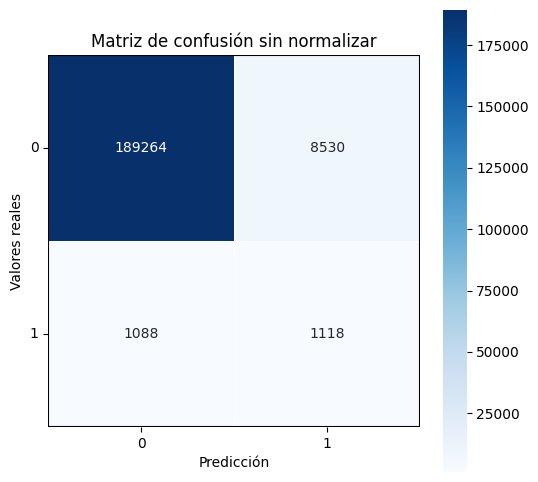

In [22]:
cm_gbt = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,6))
sns.heatmap(cm_gbt, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')

plt.title('Matriz de confusión sin normalizar')
plt.xlabel('Predicción')
plt.ylabel('Valores reales')
plt.yticks(rotation=0)

plt.gca().set_xticks([0.5, 1.5])
plt.gca().set_yticks([0.5, 1.5])
plt.gca().hlines([0, 2], 0, 2, color='black', linewidth=1.5)
plt.gca().vlines([0, 2], 0, 2, color='black', linewidth=1.5)

plt.show()

Con la matriz sin normalizar, conseguimos una visión clara de la cantidad absoluta de verdaderos positivos, negativos y falsos positivos y negativos. Es muy útil para entender la magnitud de los errores y aciertos.

En nuestro modelo, evidentemente son muy superiores el número de Verdaderos Negativos frente al resto de valores. Tenemos que los Verdaderos Positivos son muy similares a los Falsos Negativos, y como 8 veces superior el número de Falsos Positivos.
Al haber tan pocos casos de fraude, es muy similar el número de fraudes clasificados correctamente e incorrectamente, al contario que sucede con los no fraudes

### Matriz normalizada

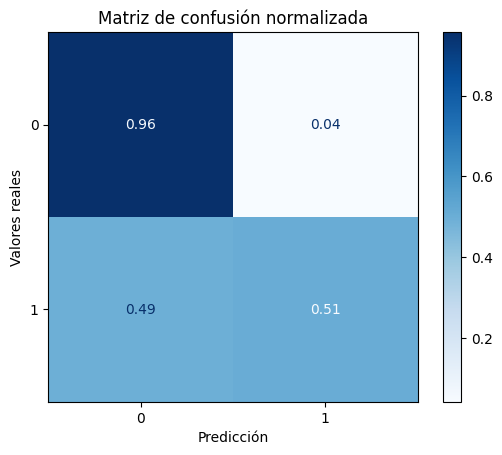

In [23]:
cm = confusion_matrix(y_test, y_pred_test, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(cmap='Blues', values_format='.2f')

plt.xlabel('Predicción')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión normalizada')

plt.show()

La matriz normalizada muestra las tasas de aciertos y errores relativos, por lo que es más útil para comprender cómo se distribuyen los errores en comparación con el tamaño total de cada clase.

Como también hemos visto en la matriz sin normalizar, es mucho más sencillo predecir los no fraudes (96% clasificados correctamente frente a un 4% clasificados incorrectamente) que los fraudes, siendo que detectamos estos últimos en aproximadamente la mitad de los casos. Si quisiésemos aumentar la proporción de detección de fraudes correctamente, la proporción de no fraudes bajaría como consecuencia

## Curva ROC

La curva ROC es una representación gráfica del rendimiento del modelo, donde el eje x representa la tasa de Falsos Positivos, y el eje y la tasa de Verdaderos Positivos. 

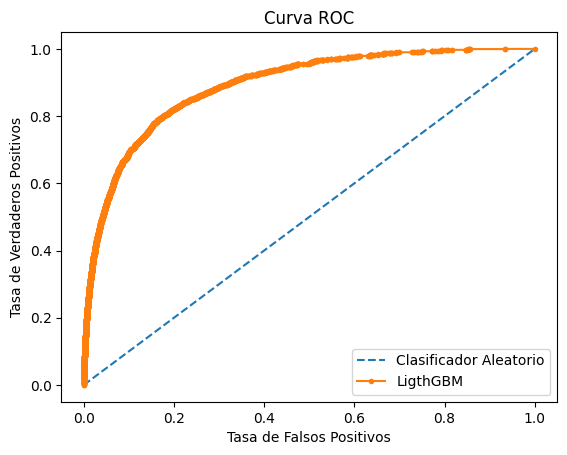

Área bajo la curva (AUC): 0.8916733987486692


In [25]:
#Probabilities calculation
y_pred_proba = light_gbm_mejor.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

#Area under the curve calculation
auc = roc_auc_score(y_test, y_pred_proba)

#ROC curve's graphic
plt.plot([0,1], [0,1], linestyle='--', label='Clasificador Aleatorio')
plt.plot(fpr, tpr, marker='.', label='LigthGBM')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()

plt.show()

print("Área bajo la curva (AUC):", auc)

Estamos comparando el rendimiento de nuestro modelo (curva naranja) frente a un modelo de clasificación aleatoria (recta entrecortada). El área bajo la curva nos da un valor de 0.89, que es bastante bueno ya que cuanto más cercano sea a 1 mejor va a predecir, y además es bastante mejor a 0.5, que sería el modelo de clasificación aleatoria.

Observando el gráfico, vemos que donde el eje x vale 0.2, el eje y es aproximadamente 0.8, y parece que donde el eje x es 0.3, el eje y es 0.9. Esto significa que cogiendo aproximadamente un 30% de los Falsos Positivos, estaríamos abarcando el 90% de los Verdaderos Positivos, siendo este probablemente el punto más óptimo ya que a partir de 0.3 en el eje x disminuye drásticamente la captación de Verdaderos Positivos

## Curva Ganancia

La curva de ganancia es otra forma de representación gráfica del rendimiento de nuestro modelo, pero comparando la cantidad de positivos que detecta el modelo frente al porcentaje de muestra que ha utilizado.

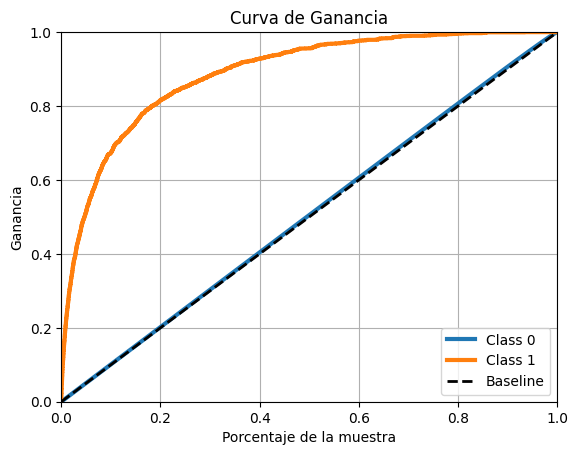

In [29]:
#Probabilities calculation
y_pred_proba_1D = light_gbm_mejor.predict_proba(X_test)

#Gain Curve's graphic
plot_cumulative_gain(y_test, y_pred_proba_1D)

plt.title("Curva de Ganancia")
plt.xlabel("Porcentaje de la muestra")
plt.ylabel("Ganancia")

plt.show()

Al igual que con la curva ROC, la curva de ganancia es una herramienta útil para evaluar el rendimiento de un modelo de clasificación. Una curva de ganancia ideal está en la parte de arriba y hacia la izquierda en el gráfico. Al observar esta curva, podemos determinar qué porcentaje de nuestra muestra podemos seleccionar para obtener cierto nivel de ganancia (clasificación de instancias positivas). En nuestro caso, al seleccionar el 20% de la muestra, el modelo es capaz de clasificar un poco más del 80% de los fraudes. Este conocimiento puede ser valioso al poner en producción el modelo, ya que nos permite tomar decisiones informadas sobre la asignación de recursos y la optimización de costos, especialmente en conjuntos de datos grandes.

## Búsqueda del umbral

En modelos de clasificación, las predicciones se generan mediante la asignación de probabilidades a cada clase. Un umbral es utilizado para convertir estas probabilidades en predicciones binarias (clasificaciones). El umbral predeterminado comúnmente es 0.5, donde se clasifica en la clase positiva si la probabilidad es mayor o igual a 0.5, y en la clase negativa si es menor. Por lo que es muy importante seleccionar un umbral óptimo para nuestro modelo, que nos permita encontrar el equilibrio que buscamos entre recall y precision.

A medida que el umbral es más pequeño, aumentará el número de predicciones hacia la clase positiva (fraude), es decir, aumentará el número de Verdaderos Positivos y disminuirá el número de Falsos Negativos, pero aumentará el número de Falsos Positivos. Es importante seleccionar un umbral que satisfaga las necesidades del problema

Light GBM: Umbral =  0.35
F2 score: 0.275


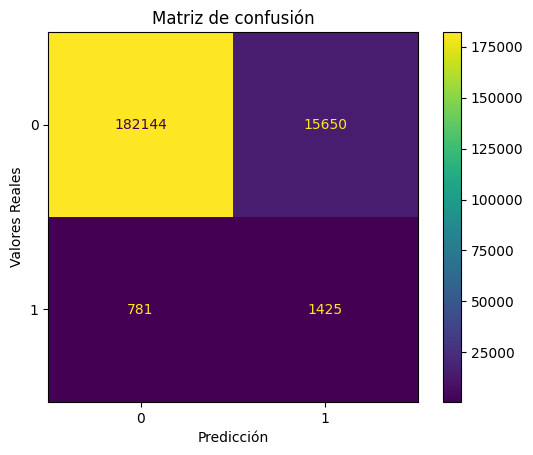

Light GBM: Umbral =  0.4
F2 score: 0.286


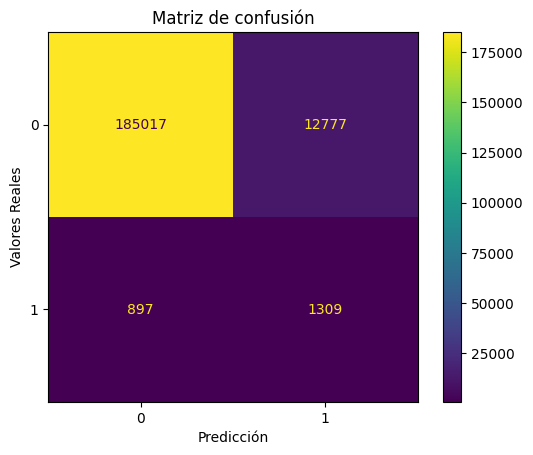

Light GBM: Umbral =  0.45
F2 score: 0.297


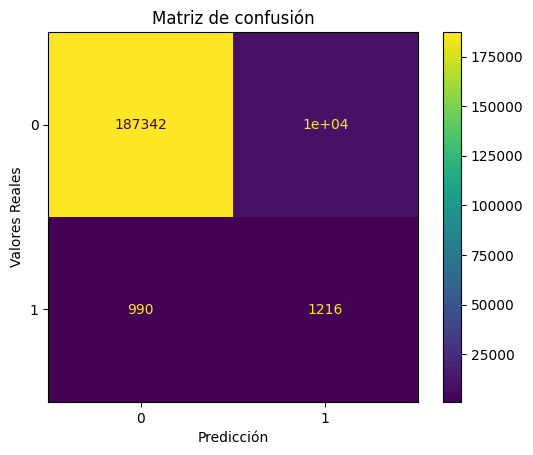

Light GBM: Umbral =  0.5
F2 score: 0.303


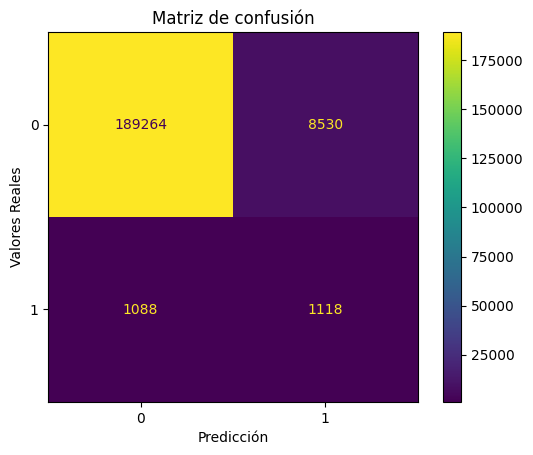

Light GBM: Umbral =  0.55
F2 score: 0.307


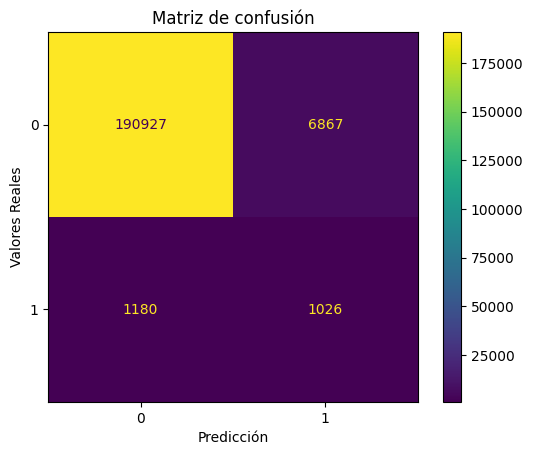

Light GBM: Umbral =  0.6
F2 score: 0.308


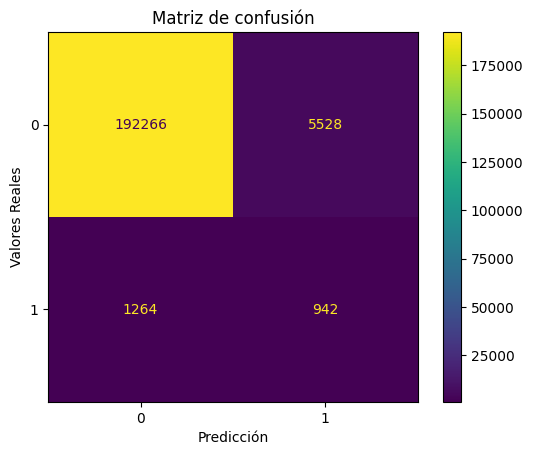

Light GBM: Umbral =  0.65
F2 score: 0.303


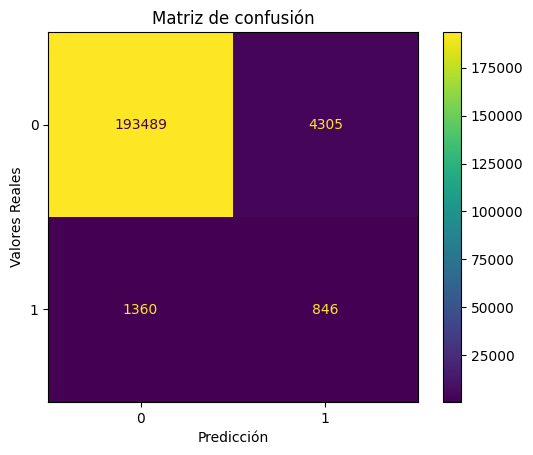

Light GBM: Umbral =  0.7
F2 score: 0.287


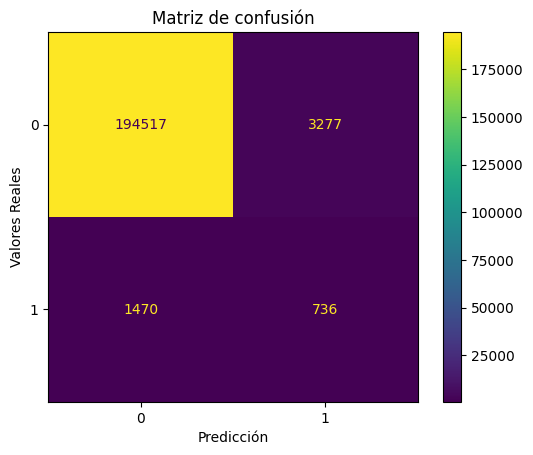

In [46]:
y_pred_proba = light_gbm_mejor.predict_proba(X_test)[:, 1]

for umbral in range(35, 71, 5):
    umbral = umbral/100
    
    #We define that if the probability is greater than the threshold it is classified as Fraud
    y_pred_light_gbm = (y_pred_proba > umbral).astype(int)
    
    #We compare a few metrics
    f2_light_gbm = fbeta_score(y_test, y_pred_light_gbm, beta=2)
    matriz_confusion_light_gbm = confusion_matrix(y_test, y_pred_light_gbm)
    
    print("Light GBM: Umbral = ", umbral)
    print("F2 score: %.3f" % f2_light_gbm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_light_gbm)
    disp.plot()
    plt.xlabel("Predicción")
    plt.ylabel("Valores Reales")
    plt.title("Matriz de confusión")
    plt.show()

Como hemos dicho antes, a medida que aumenta el umbral, se clasifican menos instancias como fraude. Podemos ver comparando las matrices de confusión que a partir del umbral 0.5 en adelante, se producen más Falsos Negativos que Verdaderos Negativos y nos gustaría evitar eso. Por el contrario, si a partir de 0.4 bajamos el umbral, se dispara el número de Falsos Positivos y tampoco queremos eso, por lo que vamos a ver algunos umbrales que ahora se encuentren entre 0.4 y 0.5

Light GBM: Umbral =  0.42
F2 score: 0.290


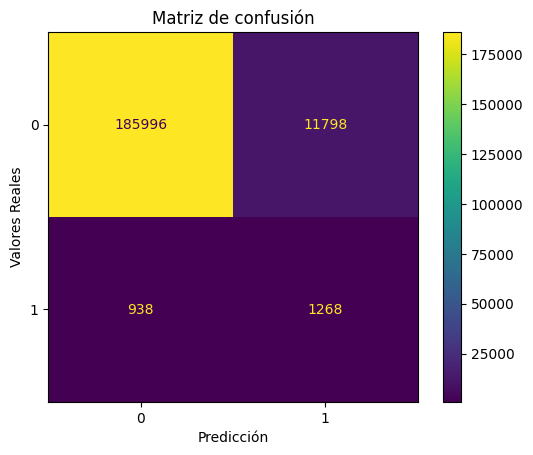

Light GBM: Umbral =  0.44
F2 score: 0.294


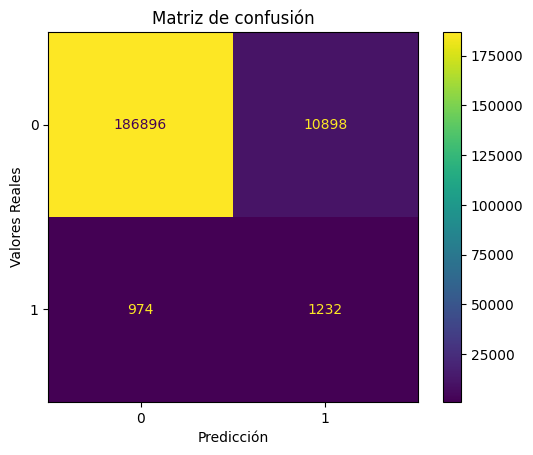

Light GBM: Umbral =  0.46
F2 score: 0.298


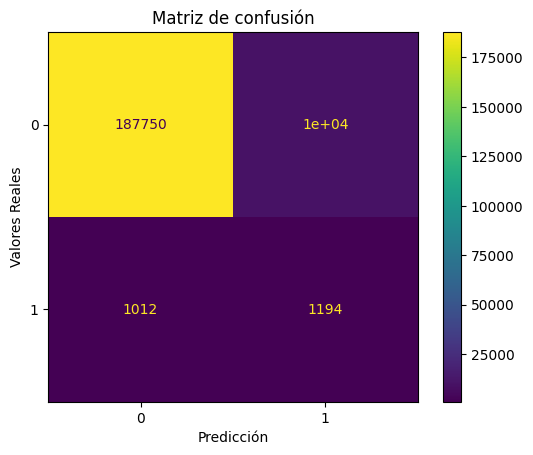

Light GBM: Umbral =  0.48
F2 score: 0.301


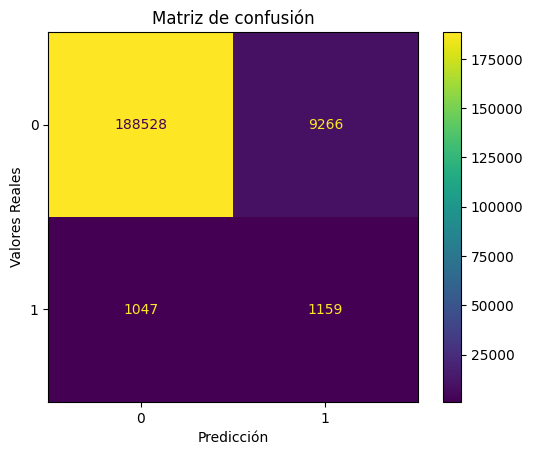

In [47]:
for umbral in [0.42, 0.44, 0.46, 0.48]:   
    #We define that if the probability is greater than the threshold it is classified as Fraud
    y_pred_light_gbm = (y_pred_proba > umbral).astype(int)
    
    #We compare a few metrics
    f2_light_gbm = fbeta_score(y_test, y_pred_light_gbm, beta=2)
    matriz_confusion_light_gbm = confusion_matrix(y_test, y_pred_light_gbm)
    
    print("Light GBM: Umbral = ", umbral)
    print("F2 score: %.3f" % f2_light_gbm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_light_gbm)
    disp.plot()
    plt.xlabel("Predicción")
    plt.ylabel("Valores Reales")
    plt.title("Matriz de confusión")
    plt.show()

Entre los nuevos umbrales, quizá la opción que da los resultados que más nos gustan es el umbral de 0.44, con un F2-score de 0.29

Como ya dijimos en el notebook de Modelización, resulta un poco complicado determinar cuantos Falsos Positivos compensa cometer con el fin de evitar un Falso Negativo, por eso queremos dejar claro que hemos realizado la selección del umbral simplemente basada en nuestra opinión de lo que sería un resultado aceptable, dejando abierta la posibilidad de realizar un estudio donde se analizase el coste que supondrían estas decisiones

## Conclusión

Una vez seleccionado el modelo final, hay una largo camino por delante en la exploración de combianciones y búsqueda de hiperparámetros. Para nuestro problema llegamos a la conclusión de que un RandomizedSearchCV era la mejor opción debido a la falta de recursos, pero en un ámbito de empresa, podría ser interesante hacer una búsqueda más exhaustiva de los hiperparámetros utilizando el GridSerachCV. 

Otro aspecto importante de este notebook son las diversas curvas que nos ayudan a entender el rendimiento de nuestro modelo. Hemos decidido no emplear demasiadas para no tener un notebook muy extenso pero podría considerarse el usar otras curvas. 

Por útlimo, la elección del umbral es fundamental ya que nos permite ajustar el modelo según lo que estemos buscando, pero sería mucho más efectiva conociendo el coste de tener Falsos Positivos frente a Falsos Negativos, que en nuestro caso no ha sido posible y lo hemos realizado según nuestra opinión